# Imports

In [1]:
import requests
import os
import logging
import gdown
import random

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import torchmetrics
import torchvision
import albumentations as A
import torchvision.transforms as T

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import cv2
from PIL import Image

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.io import loadmat
from sklearn.manifold import TSNE
from torchmetrics.functional.classification import multiclass_accuracy
from torchmetrics.classification import MulticlassF1Score, JaccardIndex, MulticlassPrecision, MulticlassRecall, MulticlassAveragePrecision
import pandas as pd
import torchinfo
import wandb
from tqdm.auto import tqdm

# Device Config

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
logging.basicConfig(level=logging.ERROR)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3090


# Environment Config

In [3]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)
# Device configuration
device = torch.device("cuda")
# Assign the Device mps
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: madhava20217 (madkri). Use `wandb login --relogin` to force relogin


True

# Loading the Data

In [7]:
ROOT_DIR = 'Datasets/ocular-disease-recognition-odir5k/'

In [8]:
IMAGE_FOLDER = ROOT_DIR + '/preprocessed_images'
CSV_PATH = ROOT_DIR + '/dataset_single_eye.csv'
HIST_IMAGE_FOLDER = ROOT_DIR + '/preprocessed_histeq_images'

In [9]:
csv = pd.read_csv(CSV_PATH)

csv = csv[csv['NOT DECISIVE'] == 0]

csv['img_exists'] = csv['Image'].apply(lambda x: os.path.isfile(IMAGE_FOLDER + "/" + x))

# drop the rows for which the file does not exist
csv = csv[csv['img_exists']]

csv.drop(columns = ['ID', 'eye', 'Patient Age',	'Patient Sex', 'NOT DECISIVE', 'img_exists'], inplace = True)
csv

,Image,N,D,G,C,A,H,M,O
0,970_right.jpg,0,0,0,1,0,0,0,0
1,127_left.jpg,0,1,0,0,0,0,0,0
2,850_right.jpg,0,1,0,0,0,0,0,0
3,37_right.jpg,1,0,0,0,0,0,0,0
4,4421_right.jpg,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
5733,199_left.jpg,0,0,0,0,0,0,0,1
5734,516_right.jpg,0,1,0,0,0,0,0,0
5735,4603_left.jpg,0,1,0,0,0,0,0,0
5736,2132_right.jpg,1,0,0,0,0,0,0,0


In [10]:
X = csv['Image'].to_numpy()
Y = csv.drop(['Image'], axis = 1).to_numpy()

print(X.shape)
print(Y.shape)

(5738,)
(5738, 8)


In [11]:
class ODIRDataset(Dataset) :
    
    def __init__(self, X, Y, IMG_FOLDER, HIST_IMG_FOLDER, transform = None) :
        
        '''
        id : list of samples ids as string
        '''

        self.images = X
        self.labels = Y
        self.image_dir = IMG_FOLDER
        self.hist_image_dir = HIST_IMG_FOLDER
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.image_dir, self.images[idx])
        hist_img_path = os.path.join(self.hist_image_dir, self.images[idx])
        
        #image = Image.open(img_path).convert("RGB")
        #hist_image = Image.open(hist_img_path)
        image = torchvision.io.read_image(img_path)
        #hist_image = torchvision.io.read_image(hist_img_path)

        labels = torch.Tensor(self.labels[idx]).long()
        t = T.Resize((480,480),interpolation=torchvision.transforms.InterpolationMode.NEAREST)
        image = t(image)#.long()
    
        image = image.numpy()
        if(self.transform != None) :
            image = np.transpose(image, (1,2,0))
            image = self.transform(image = image)['image']
#             print(image)
            image = np.transpose(image, (2,0,1))
          #hist_image = self.transform(hist_image)
        image=torch.tensor(image)

        #return image, hist_image, labels
        return image, labels

In [12]:
def train_val_test_split(dataset, train_percent=0.75, val_percent=0.15, test_percent=0.1, seed=None):
    
    # Given a pytorch Dataset, split it

    assert len(X) == len(Y), "X and Y should have the same length"
    assert round(train_percent + val_percent + test_percent,1) == 1.0, "Train, validation, and test percentages should add up to 1.0"

    if seed is not None:
        np.random.seed(seed)
    
    train_size = int(train_percent * len(dataset))
    val_size = int(val_percent * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # use random_split to split the dataset into train, val, and test sets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

In [13]:
BATCH_SIZE = 2
RANDOM_SEED = 69

In [14]:
transform = A.Compose([
        A.OneOf([A.RandomRotate90(), A.Rotate(limit=[45,45], p=0.5, border_mode=cv2.BORDER_CONSTANT)]),
        A.augmentations.geometric.transforms.Affine(scale=None, translate_percent=None, translate_px=5, rotate=None, shear=None)
    ]
)

In [15]:
ODIR_Dataset = ODIRDataset(X, Y, IMAGE_FOLDER, HIST_IMAGE_FOLDER, transform = transform)

train_dataset, val_dataset, test_dataset = train_val_test_split(ODIR_Dataset, 0.9, 0.0, 0.1, RANDOM_SEED)
val_dataset.transform = None
test_dataset.transform = None

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

5164
0
574


torch.Size([3, 480, 480])


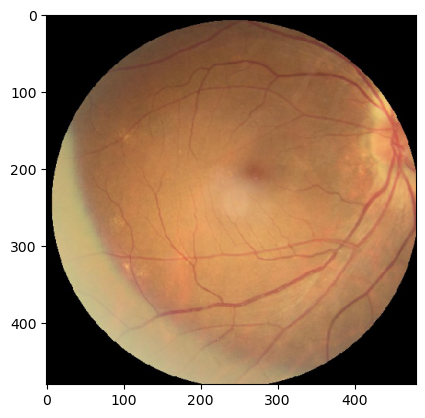

tensor([0, 0, 0, 0, 0, 0, 0, 1])


In [17]:
train_sample, train_label = train_dataset[7]

print(train_sample.shape)
#print(train_hist_sample.shape)

image_array = np.transpose(train_sample, (1, 2, 0))
plt.imshow(image_array)
plt.show()
# print(train_sample)
print(train_label)

In [18]:
# image_array = np.transpose(train_hist_sample, (1, 2, 0))
# plt.imshow(image_array, cmap = 'gray')
# plt.show()

torch.Size([2, 3, 480, 480])
torch.Size([2, 8])


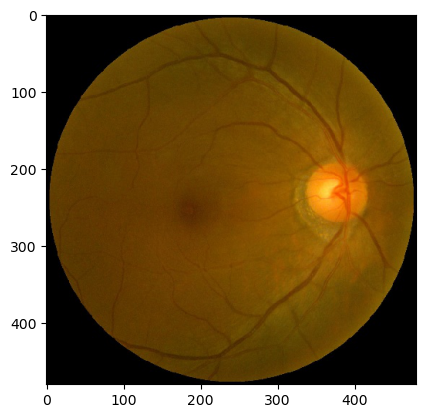

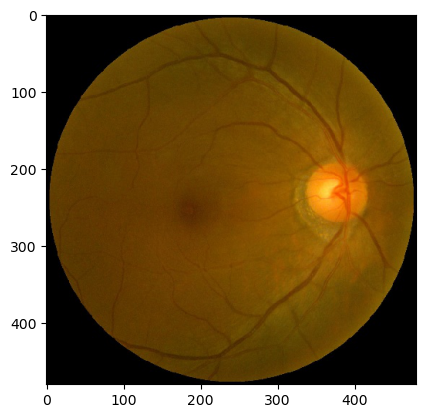

In [19]:
for batch_idx, (data, targets) in enumerate((train_dataloader)):

    data = data.to(device=device)
    #hist_data = data_hist.to(device=device)
    targets = targets.to(device=device)

    print(data.shape)
    #print(hist_data.shape)
    print(targets.shape)

    img1 = data[0] 
    #img2 = hist_data[0]

    image_array = np.transpose(img1.to('cpu').numpy(), (1, 2, 0))
    plt.imshow(image_array)

    plt.show()

    #image_array = np.transpose(img2.to('cpu').numpy(), (1, 2, 0))
    plt.imshow(image_array, cmap = 'gray')

    plt.show()

    break

# Model Setup

In [20]:
model = torchvision.models.efficientnet_b3(parameters = {'weights': torchvision.models.EfficientNet_B3_Weights.DEFAULT}).to(device)

In [21]:
torchinfo.summary(model, (50, 3, 480, 480))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [50, 1000]                --
├─Sequential: 1-1                                       [50, 1536, 15, 15]        --
│    └─Conv2dNormActivation: 2-1                        [50, 40, 240, 240]        --
│    │    └─Conv2d: 3-1                                 [50, 40, 240, 240]        1,080
│    │    └─BatchNorm2d: 3-2                            [50, 40, 240, 240]        80
│    │    └─SiLU: 3-3                                   [50, 40, 240, 240]        --
│    └─Sequential: 2-2                                  [50, 24, 240, 240]        --
│    │    └─MBConv: 3-4                                 [50, 24, 240, 240]        2,298
│    │    └─MBConv: 3-5                                 [50, 24, 240, 240]        1,206
│    └─Sequential: 2-3                                  [50, 32, 120, 120]        --
│    │    └─MBConv: 3-6                            

In [22]:
num_ftrs = model.classifier[1].in_features

In [23]:
num_ftrs

1536

In [24]:
NUM_CLASSES = 8

In [25]:
model.classifier[1] = torch.nn.Linear(in_features=num_ftrs, out_features=NUM_CLASSES, bias=True)
model.classifier[0] = torch.nn.Dropout(p=0.5, inplace=True)

In [26]:
torchinfo.summary(model, (50, 3, 480, 480))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [50, 8]                   --
├─Sequential: 1-1                                       [50, 1536, 15, 15]        --
│    └─Conv2dNormActivation: 2-1                        [50, 40, 240, 240]        --
│    │    └─Conv2d: 3-1                                 [50, 40, 240, 240]        1,080
│    │    └─BatchNorm2d: 3-2                            [50, 40, 240, 240]        80
│    │    └─SiLU: 3-3                                   [50, 40, 240, 240]        --
│    └─Sequential: 2-2                                  [50, 24, 240, 240]        --
│    │    └─MBConv: 3-4                                 [50, 24, 240, 240]        2,298
│    │    └─MBConv: 3-5                                 [50, 24, 240, 240]        1,206
│    └─Sequential: 2-3                                  [50, 32, 120, 120]        --
│    │    └─MBConv: 3-6                            

In [27]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

# Pipeline Setup

### Making Normal Image Model

In [28]:
config = dict(
    epochs = 10, 
    classes = 8,
    batch_size = 15,
    dataset = "ODIRDataset_2019",
    train_split = 0.7,
    val_split = 0.2,
    test_split = 0.1,
    learning_rate=0.001,
    device="cuda",
    shuffle_dataset=True,
    architecture="EfficientNet")

In [29]:
def model_pipeline(hyperparameters):
    # tell wandb to get started
    with wandb.init(project="DL-Ocular-Baseline1", config=hyperparameters, settings=wandb.Settings(symlink=False), reinit=True):
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config
        # make the model, data, and optimization problem
        model, train_loader, val_loader, test_loader, criterion, optimizer = make(config)

        # print(model)
        # and use them to train the model
        train(model, train_loader, val_loader, criterion, optimizer, config)
        # and test its final performance
        model = test(model, test_loader)
    return model, train_loader, val_loader, test_loader

In [30]:
class weightedClassBCE(nn.Module):
    def __init__(self, NUM_CLASSES, weight_class):
        super(weightedClassBCE, self).__init__()
        self.NUM_CLASSES = NUM_CLASSES
        self.weight_class = weight_class

    def forward(self, output, target):
        loss_weight = self.weight_class
        sig = nn.Sigmoid()
        output = torch.transpose(sig(output), 0, 1)
        target = torch.transpose(target, 0, 1).float()
        criterion = nn.BCELoss()
        loss_sum = torch.tensor(0.0, requires_grad = True)
        weight_sum = 0
        for i in range(self.NUM_CLASSES):
            # y_actual = target[i], y_pred = output[i]
            loss_sum += loss_weight[i]*(-(target[i] * torch.log(output[i]) + (1 - target[i]) * torch.log(1 - output[i])))
            weight_sum += loss_weight[i]
        #netLoss = loss_sum/weight_sum
        return loss_sum/weight_sum#torch.tensor(netLoss, requires_grad=True)

In [31]:
transform = A.Compose([
        A.OneOf([A.RandomRotate90(), A.Rotate(limit=[45,45], p=0.5, border_mode=cv2.BORDER_CONSTANT)]),
        A.augmentations.geometric.transforms.Affine(scale=None, translate_percent=None, translate_px=5, rotate=None, shear=None)
    ]
)

In [32]:
def make(config):
    # Make the data
    transform = A.Compose([
            A.OneOf([A.RandomRotate90(), A.Rotate(limit=[45,45], p=0.5, border_mode=cv2.BORDER_CONSTANT)]),
            A.augmentations.geometric.transforms.Affine(scale=None, translate_percent=None, translate_px=5, rotate=None, shear=None)
        ]
    )
    train_dataset, val_dataset, test_dataset = train_val_test_split(ODIRDataset(X, Y, IMAGE_FOLDER, HIST_IMAGE_FOLDER, transform = transform), config['train_split'], config['val_split'], config['test_split'], RANDOM_SEED)
    val_dataset.transform = None
    test_dataset.transform = None
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=config['shuffle_dataset'])
    if(len(val_dataset) != 0):
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=config['shuffle_dataset'])
    else:
        val_loader = None
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=config['shuffle_dataset'])
    
    
    # Make the model
    model = torchvision.models.efficientnet_b3(parameters = {'weights': torchvision.models.EfficientNet_B3_Weights.DEFAULT}).to(device)
    num_ftrs = model.classifier[1].in_features
    NUM_CLASSES = 8
    weight_class = torch.tensor([1,1.2,1.5,1.5,1.5,1.5, 1.5, 1.2]).to(device)
    model.classifier[1] = torch.nn.Linear(in_features=num_ftrs, out_features=NUM_CLASSES, bias=True)
    model.classifier[0] = torch.nn.Dropout(p=0.5, inplace=True)
    model = model.to(config['device'])

    # Make the loss and optimizer
    criterion = torch.nn.BCELoss(weight_class)#weightedClassBCE(NUM_CLASSES, weight_class)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, val_loader, test_loader, criterion, optimizer

In [33]:
def train(model, loader, val_loader, criterion, optimizer, config):
    torch.cuda.empty_cache()
    wandb.watch(model, criterion, log="all", log_freq=10)
    # Run training and track with wandb
    model.train()
    total_batches = len(loader) * config.epochs
    example_ct = 0  
    batch_ct = 0
    for epoch in tqdm(range(1,config.epochs+1)):
        print("Epoch: {}".format(epoch))
        model.train()
        correct = np.asarray([0, 0, 0, 0, 0, 0, 0, 0])
        correct_classified = 0
        total = 0
        tl = 0
        s = 0
        for batch_idx, (data, targets) in enumerate((loader)):
            loss, outputs = train_batch(data, targets, model, optimizer, criterion)

            #print("MODEL WEIGHT {}: \n\n\n\n\n".format(batch_idx), model.layer[0].weight)
            example_ct +=  len(data)
            batch_ct += 1
            tl += loss*len(outputs)
            s += len(outputs)
            
            predicted = torch.round(outputs)
            
            total += targets.size(0)
            correct += (predicted.to("cpu") == targets.to("cpu")).sum(0).numpy()
            correct_classified+= (predicted.to('cpu') == targets.to('cpu')).sum()

            if(batch_idx % 50 == 0):
                print("BATCH {}".format(batch_idx))
            
        acc_class = correct/total
        net_acc = correct_classified/(total*8)
        print(f"Train Accuracy: {net_acc:.3f}")
        print(f"Train Loss: {tl/s:.3f}")
        train_log(tl/s, example_ct, epoch)
        wandb.log({"Train Accuracy": net_acc}, step=epoch)
        for cl in range(8):
            wandb.log({("Train Accuracy for class "+str(cl)): acc_class[cl]}, step=epoch)
        torch.cuda.empty_cache()
    
        #validate here
        if(val_loader == None):
            continue
        correct_classified = 0
        total = 0
        tl = 0
        s = 0

        model.eval()
        for batch_idx, (data, targets) in enumerate(val_loader):
            data = data.to(device).float()
            targets = targets.to(device)
            with torch.no_grad():
                outputs = torch.sigmoid(model(data))
                loss = criterion(outputs, targets.float().to(device))
                tl += loss*len(outputs)
                s += len(outputs)
                predicted = torch.round(outputs)
                correct_classified += (predicted.to('cpu') == targets.to('cpu')).sum()
                total += targets.size(0)
                
        val_los_epoch = tl/s
        val_acc_epoch = correct_classified/(total*8)

        print("Validation Accuracy: {:.3f} \nValidation Loss: {:.3f} \n".format(val_acc_epoch, val_los_epoch))
        wandb.log({"Validation Accuracy": val_acc_epoch, "Validation Loss": val_los_epoch}, step=epoch)
        torch.cuda.empty_cache()

def train_batch(data, targets, model, optimizer, criterion):
    data, targets = data.to(device), targets.to(device)
    data = data.float().to(device)
    # Forward pass ➡
    outputs = model(data)
    outputs = torch.sigmoid(outputs)
    loss = criterion(outputs, targets.float().to(device))
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()
    return loss, outputs

In [34]:
def train_log(loss, example_ct, epoch):
    wandb.log({"Train Loss": loss}, step=epoch)

In [35]:
def test(model, test_loader):
    model.eval()
    # Run the model on some test examples
    with torch.no_grad():
        correct_classified = 0
        total = 0
        for batch_idx, (data, targets) in enumerate(test_loader):
            data = data.to(device).float()
            targets = targets.to(device)
            outputs = torch.sigmoid(model(data))
            predicted = torch.round(outputs)
            correct_classified += (predicted.to('cpu') == targets.to('cpu')).sum()
            total += targets.size(0)
                
        test_acc = correct_classified/(total*8)

        print("Accuracy on the Test Set: {:.3f}\n".format(test_acc))
        wandb.log({"Accuracy on the Test Set": test_acc})
        torch.cuda.empty_cache()
        
    # Save the model
    torch.onnx.export(model, data, "efficientNet_normal.onnx")
    wandb.save("efficientNet_normal.onnx")
    
    name = "efficientNet_normal.pth"
    torch.save(model.state_dict(), name)
    return model

In [36]:
def load_model(path,num_classes=8,device="cpu"):
    model = torchvision.models.efficientnet_b3(parameters = {'weights': torchvision.models.EfficientNet_B3_Weights.DEFAULT}).to(device)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
    model.classifier[0] = torch.nn.Dropout(p=0.5, inplace=True)
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    return model

In [37]:
model, train_loader, val_loader, test_loader = model_pipeline(config)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.870
Train Loss: 0.391
Validation Accuracy: 0.875 
Validation Loss: 0.376 

Epoch: 2
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.871
Train Loss: 0.373
Validation Accuracy: 0.875 
Validation Loss: 0.361 

Epoch: 3
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.874
Train Loss: 0.368
Validation Accuracy: 0.875 
Validation Loss: 0.359 

Epoch: 4
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.874
Train Loss: 0.364
Validation Accuracy: 0.875 
Validation Loss: 0.355 

Epoch: 5
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.875
Train Loss: 0.353
Validation Accuracy: 0.875 
Validation Loss: 0.355 

Epoch: 6
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.877
Train Loss: 0.343
Validation Accuracy: 0.880 
Validation Loss: 0.332 

Epoch: 7
BATCH 0
BATCH 50
BATCH 100
BATCH 150


c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\wandb\wandb_torch.py:303: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\wandb\wandb_torch.py:303: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\wandb\wandb_torch.py:306: TracerWarning: Converting a tensor to a Python boolean might cause the tra

Accuracy on the Test Set,▁
Train Accuracy,▁▂▄▃▄▅▆▇▇█
Train Accuracy for class 0,▂▁▃▃▄▅▆▆▇█
Train Accuracy for class 1,▁▆▇█▇▇▅█▂▄
Train Accuracy for class 2,▁█████████
Train Accuracy for class 3,▁▃▃▃▃▃▄▆▇█
Train Accuracy for class 4,▁█████████
Train Accuracy for class 5,▁█████████
Train Accuracy for class 6,▁▂▂▂▂▄▅▆█▆
Train Accuracy for class 7,▁█████████
Train Loss,█▆▆▅▄▃▂▂▁▁


In [38]:
def indi_test(model, test_loader):
    model.eval()
    # Run the model on some test examples
    with torch.no_grad():
        correct_classified = 0
        total = 0
        for batch_idx, (data, targets) in enumerate(test_loader):
            data = data.float().to(device)
            targets = targets.to(device)
            outputs = torch.sigmoid(model(data))
            predicted = torch.round(outputs)
            correct_classified += (predicted.to('cpu') == targets.to('cpu')).sum()
            total += targets.size(0)
                
        test_acc = correct_classified/(total*8)

        print("Accuracy on the Test Set: {:.3f}\n".format(test_acc))
        torch.cuda.empty_cache()

In [39]:
model = load_model("efficientNet_normal.pth",num_classes=8,device="cuda")

In [40]:
indi_test(model, test_dataloader)#test_loader)

Accuracy on the Test Set: 0.880



### Making Hor Eq Model

In [41]:
class ODIRDataset(Dataset) :
    
    def __init__(self, X, Y, IMG_FOLDER, HIST_IMG_FOLDER, transform = None) :
        
        '''
        id : list of samples ids as string
        '''

        self.images = X
        self.labels = Y
        self.image_dir = IMG_FOLDER
        self.hist_image_dir = HIST_IMG_FOLDER
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.image_dir, self.images[idx])
        hist_img_path = os.path.join(self.hist_image_dir, self.images[idx])
        hist_image = torchvision.io.read_image(hist_img_path)

        labels = torch.Tensor(self.labels[idx]).long()
        t = T.Resize((480,480),interpolation=torchvision.transforms.InterpolationMode.NEAREST)
        image = t(hist_image)
    
        hist_image = hist_image.numpy()
        if(self.transform != None) :
            hist_image = np.transpose(hist_image, (1,2,0))
            hist_image = self.transform(image = hist_image)['image']
#             print(image)
            hist_image = np.transpose(hist_image, (2,0,1))
        hist_image=torch.tensor(hist_image)

        return hist_image, labels

In [42]:
def train_val_test_split(dataset, train_percent=0.75, val_percent=0.15, test_percent=0.1, seed=None):
    
    # Given a pytorch Dataset, split it

    assert len(X) == len(Y), "X and Y should have the same length"
    assert round(train_percent + val_percent + test_percent,1) == 1.0, "Train, validation, and test percentages should add up to 1.0"

    if seed is not None:
        np.random.seed(seed)
    
    train_size = int(train_percent * len(dataset))
    val_size = int(val_percent * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # use random_split to split the dataset into train, val, and test sets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

In [43]:
BATCH_SIZE = 2
RANDOM_SEED = 69

In [44]:
transform = A.Compose([
        A.OneOf([A.RandomRotate90(), A.Rotate(limit=[45,45], p=0.5, border_mode=cv2.BORDER_CONSTANT)]),
        A.augmentations.geometric.transforms.Affine(scale=None, translate_percent=None, translate_px=5, rotate=None, shear=None)
    ]
)

In [45]:
ODIR_Dataset = ODIRDataset(X, Y, IMAGE_FOLDER, HIST_IMAGE_FOLDER, transform = transform)

train_dataset, val_dataset, test_dataset = train_val_test_split(ODIR_Dataset, 0.9, 0.0, 0.1, RANDOM_SEED)
val_dataset.transform = None
test_dataset.transform = None

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

5164
0
574


torch.Size([1, 512, 512])


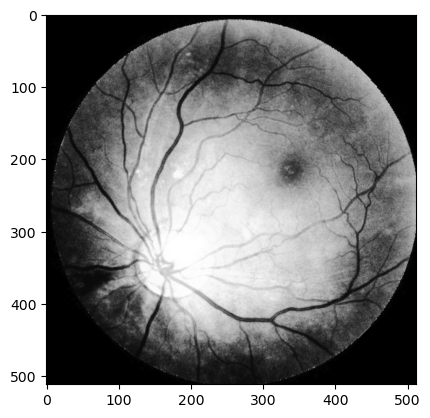

tensor([0, 1, 0, 0, 0, 0, 0, 0])


In [47]:
train_sample, train_label = train_dataset[7]

print(train_sample.shape)
#print(train_hist_sample.shape)

image_array = np.transpose(train_sample, (1, 2, 0))
plt.imshow(image_array, cmap = 'gray')
plt.show()
# print(train_sample)
print(train_label)

torch.Size([2, 1, 512, 512])
torch.Size([2, 8])


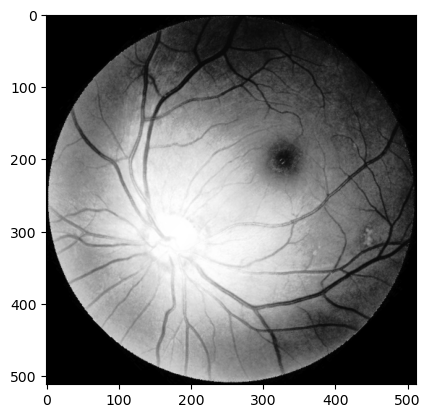

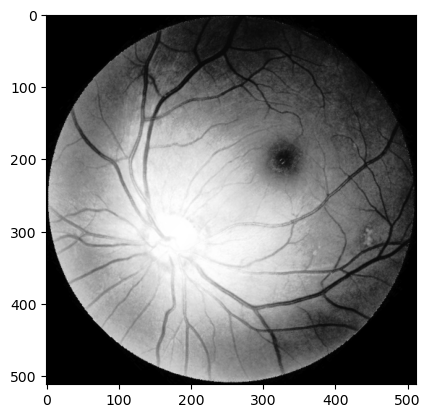

In [48]:
for batch_idx, (data, targets) in enumerate((train_dataloader)):

    data = data.to(device=device)
    #hist_data = data_hist.to(device=device)
    targets = targets.to(device=device)

    print(data.shape)
    #print(hist_data.shape)
    print(targets.shape)

    img1 = data[0] 
    #img2 = hist_data[0]

    image_array = np.transpose(img1.to('cpu').numpy(), (1, 2, 0))
    plt.imshow(image_array, cmap = 'gray')

    plt.show()

    #image_array = np.transpose(img2.to('cpu').numpy(), (1, 2, 0))
    plt.imshow(image_array, cmap = 'gray')

    plt.show()

    break

In [49]:
def test(model, test_loader):
    model.eval()
    # Run the model on some test examples
    with torch.no_grad():
        correct_classified = 0
        total = 0
        for batch_idx, (data, targets) in enumerate(test_loader):
            data = data.to(device).float()
            targets = targets.to(device)
            outputs = torch.sigmoid(model(data))
            predicted = torch.round(outputs)
            correct_classified += (predicted.to('cpu') == targets.to('cpu')).sum()
            total += targets.size(0)
                
        test_acc = correct_classified/(total*8)

        print("Accuracy on the Test Set: {:.3f}\n".format(test_acc))
        wandb.log({"Accuracy on the Test Set": test_acc})
        torch.cuda.empty_cache()
        
    # Save the model
    torch.onnx.export(model, data, "efficientNet_grey.onnx")
    wandb.save("efficientNet_greyl.onnx")
    
    name = "efficientNet_grey.pth"
    torch.save(model.state_dict(), name)
    return model

In [50]:
def make(config):
    # Make the data
    transform = A.Compose([
            A.OneOf([A.RandomRotate90(), A.Rotate(limit=[45,45], p=0.5, border_mode=cv2.BORDER_CONSTANT)]),
            A.augmentations.geometric.transforms.Affine(scale=None, translate_percent=None, translate_px=5, rotate=None, shear=None)
        ]
    )
    train_dataset, val_dataset, test_dataset = train_val_test_split(ODIRDataset(X, Y, IMAGE_FOLDER, HIST_IMAGE_FOLDER, transform = transform), config['train_split'], config['val_split'], config['test_split'], RANDOM_SEED)
    val_dataset.transform = None
    test_dataset.transform = None
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=config['shuffle_dataset'])
    if(len(val_dataset) != 0):
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=config['shuffle_dataset'])
    else:
        val_loader = None
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=config['shuffle_dataset'])
    
    
    # Make the model
    model = torchvision.models.efficientnet_b3(parameters = {'weights': torchvision.models.EfficientNet_B3_Weights.DEFAULT}).to(device)
    num_ftrs = model.classifier[1].in_features
    NUM_CLASSES = 8
    weight_class = torch.tensor([1,1.2,1.5,1.5,1.5,1.5, 1.5, 1.2]).to(device)
    model.features[0][0] = torch.nn.Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[1] = torch.nn.Linear(in_features=num_ftrs, out_features=NUM_CLASSES, bias=True)
    model.classifier[0] = torch.nn.Dropout(p=0.5, inplace=True)
    model = model.to(config['device'])

    # Make the loss and optimizer
    criterion = torch.nn.BCELoss(weight_class)#weightedClassBCE(NUM_CLASSES, weight_class)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, val_loader, test_loader, criterion, optimizer

In [51]:
model, train_loader, val_loader, test_loader = model_pipeline(config)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.871
Train Loss: 0.392
Validation Accuracy: 0.876 
Validation Loss: 0.364 

Epoch: 2
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.871
Train Loss: 0.367
Validation Accuracy: 0.874 
Validation Loss: 0.361 

Epoch: 3
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.873
Train Loss: 0.361
Validation Accuracy: 0.874 
Validation Loss: 0.354 

Epoch: 4
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.874
Train Loss: 0.354
Validation Accuracy: 0.875 
Validation Loss: 0.356 

Epoch: 5
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.874
Train Loss: 0.348
Validation Accuracy: 0.867 
Validation Loss: 0.369 

Epoch: 6
BATCH 0
BATCH 50
BATCH 100
BATCH 150
BATCH 200
BATCH 250
Train Accuracy: 0.875
Train Loss: 0.342
Validation Accuracy: 0.878 
Validation Loss: 0.331 

Epoch: 7
BATCH 0
BATCH 50
BATCH 100
BATCH 150


c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\wandb\wandb_torch.py:303: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\wandb\wandb_torch.py:303: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\wandb\wandb_torch.py:306: TracerWarning: Converting a tensor to a Python boolean might cause the tra

Accuracy on the Test Set,▁
Train Accuracy,▁▁▂▄▄▅▅█▅█
Train Accuracy for class 0,▅▁▃▄▅▆▄█▃█
Train Accuracy for class 1,▁▆▇▇▅▇█▇▇▆
Train Accuracy for class 2,▁█████████
Train Accuracy for class 3,▁▁▁▂▄▄▆▇█▇
Train Accuracy for class 4,▁█████████
Train Accuracy for class 5,▁█████████
Train Accuracy for class 6,▁▄▄▄▃▃▂▄▇█
Train Accuracy for class 7,▁█████████
Train Loss,█▅▄▄▃▂▂▁▁▁


In [52]:
def load_grey_model(path,num_classes=8,device="cpu"):
    model = torchvision.models.efficientnet_b3(parameters = {'weights': torchvision.models.EfficientNet_B3_Weights.DEFAULT}).to(device)
    num_ftrs = model.classifier[1].in_features
    model.features[0][0] = torch.nn.Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[1] = torch.nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
    model.classifier[0] = torch.nn.Dropout(p=0.5, inplace=True)
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    return model

In [53]:
grey_model = load_grey_model("efficientNet_grey.pth",num_classes=8,device="cuda")

In [54]:
indi_test(grey_model, test_dataloader)#test_loader)

Accuracy on the Test Set: 0.886



## ENSEMBLE STRATEGY

In [55]:
# def combined_efficientNet(normal_path, grey_path):
#     grey_model = load_grey_model("efficientNet_grey.pth",num_classes=8,device="cuda")

In [56]:
class combined_efficientNet():    
    def __init__(self, normal_path, grey_path) :
        self.normal_efficientNet = load_model(normal_path,num_classes=8,device="cuda")
        self.grey_efficientNet = load_grey_model(grey_path,num_classes=8,device="cuda")
        
    def test_sample(self, sample, sample_hist):
        output_normal = torch.sigmoid(self.normal_efficientNet(sample))
        output_grey = torch.sigmoid(self.grey_efficientNet(sample_hist))
        outputs = torch.add(output_normal, output_grey)
        outputs = torch.div(outputs, 2)
        return outputs

    def test(self, test_loader):
        self.normal_efficientNet.eval()
        self.grey_efficientNet.eval()
        with torch.no_grad():
            correct_classified = 0
            total = 0
            for batch_idx, (data, data_hist, targets) in enumerate(test_loader):
                data = data.float().to(device)
                data_hist = data_hist.float().to(device)
                targets = targets.to(device)
                outputs = self.test_sample(data, data_hist)
                predicted = torch.round(outputs)
                correct_classified += (predicted.to('cpu') == targets.to('cpu')).sum()
                total += targets.size(0)

            test_acc = correct_classified/(total*8)

            print("Accuracy on the Test Set: {:.3f}\n".format(test_acc))
            torch.cuda.empty_cache()



In [57]:
class ODIRDataset(Dataset) :
    def __init__(self, X, Y, IMG_FOLDER, HIST_IMG_FOLDER, transform = None) :
        '''
        id : list of samples ids as string
        '''
        self.images = X
        self.labels = Y
        self.image_dir = IMG_FOLDER
        self.hist_image_dir = HIST_IMG_FOLDER
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.image_dir, self.images[idx])
        hist_img_path = os.path.join(self.hist_image_dir, self.images[idx])
        
        #image = Image.open(img_path).convert("RGB")
        #hist_image = Image.open(hist_img_path)
        image = torchvision.io.read_image(img_path)
        hist_image = torchvision.io.read_image(hist_img_path)

        labels = torch.Tensor(self.labels[idx]).long()
        t = T.Resize((480,480),interpolation=torchvision.transforms.InterpolationMode.NEAREST)
        image = t(image)#.long()
        hist_image = t(hist_image)
        image = image.numpy()
        hist_image = hist_image.numpy()
        if(self.transform != None) :
            image = np.transpose(image, (1,2,0))
            image = self.transform(image = image)['image']
            image = np.transpose(image, (2,0,1))
            
            hist_image = np.transpose(hist_image, (1,2,0))
            hist_image = self.transform(image = hist_image)['image']
            hist_image = np.transpose(hist_image, (2,0,1))
        image=torch.tensor(image)
        hist_image=torch.tensor(hist_image)

        return image, hist_image, labels

In [58]:
def train_val_test_split(dataset, train_percent=0.75, val_percent=0.15, test_percent=0.1, seed=None):
    
    # Given a pytorch Dataset, split it

    assert len(X) == len(Y), "X and Y should have the same length"
    assert round(train_percent + val_percent + test_percent,1) == 1.0, "Train, validation, and test percentages should add up to 1.0"

    if seed is not None:
        np.random.seed(seed)
    
    train_size = int(train_percent * len(dataset))
    val_size = int(val_percent * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # use random_split to split the dataset into train, val, and test sets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

In [59]:
BATCH_SIZE = 2
RANDOM_SEED = 69

In [60]:
transform = A.Compose([
        A.OneOf([A.RandomRotate90(), A.Rotate(limit=[45,45], p=0.5, border_mode=cv2.BORDER_CONSTANT)]),
        A.augmentations.geometric.transforms.Affine(scale=None, translate_percent=None, translate_px=5, rotate=None, shear=None)
    ]
)

In [61]:
ODIR_Dataset = ODIRDataset(X, Y, IMAGE_FOLDER, HIST_IMAGE_FOLDER, transform = None)

train_dataset, val_dataset, test_dataset = train_val_test_split(ODIR_Dataset, 0.9, 0.0, 0.1, RANDOM_SEED)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [62]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

5164
0
574


torch.Size([3, 480, 480])
torch.Size([1, 480, 480])


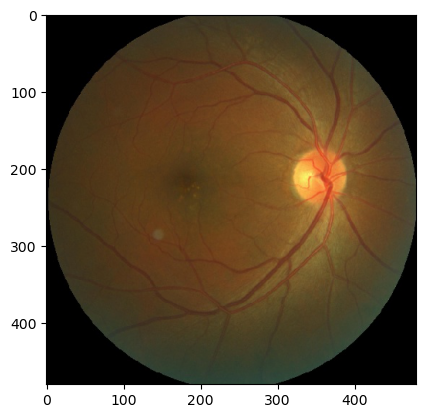

tensor([1, 0, 0, 0, 0, 0, 0, 0])


In [63]:
train_sample, train_hist_sample, train_label = train_dataset[7]

print(train_sample.shape)
print(train_hist_sample.shape)

image_array = np.transpose(train_sample, (1, 2, 0))
plt.imshow(image_array)
plt.show()
# print(train_sample)
print(train_label)

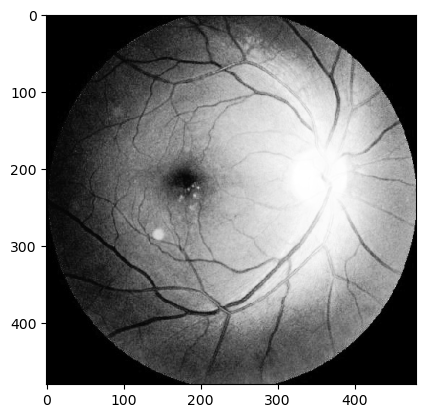

In [64]:
image_array = np.transpose(train_hist_sample, (1, 2, 0))
plt.imshow(image_array, cmap = 'gray')
plt.show()

torch.Size([2, 3, 480, 480])
torch.Size([2, 1, 480, 480])
torch.Size([2, 8])


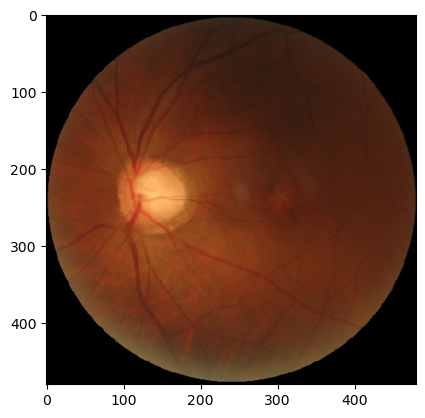

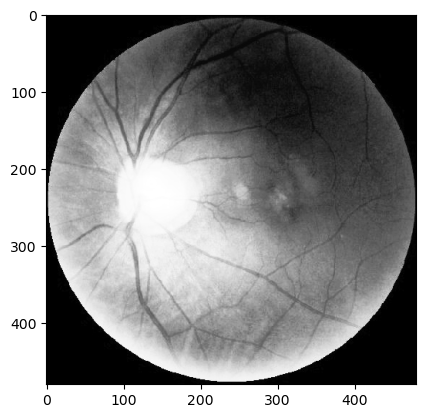

In [65]:
for batch_idx, (data, data_hist, targets) in enumerate((train_dataloader)):

    data = data.to(device=device)
    hist_data = data_hist.to(device=device)
    targets = targets.to(device=device)

    print(data.shape)
    print(hist_data.shape)
    print(targets.shape)

    img1 = data[0] 
    img2 = hist_data[0]

    image_array = np.transpose(img1.to('cpu').numpy(), (1, 2, 0))
    plt.imshow(image_array)

    plt.show()

    image_array = np.transpose(img2.to('cpu').numpy(), (1, 2, 0))
    plt.imshow(image_array, cmap = 'gray')

    plt.show()

    break

In [66]:
EfficientNet = combined_efficientNet("efficientNet_normal.pth", "efficientNet_grey.pth")

In [67]:
EfficientNet.test(test_dataloader)

Accuracy on the Test Set: 0.880

